# WISDM HAR

Class
- Walking, Jogging, Upstairs, Downstairs, Sitting, Standing

Sampling rate
- 20Hz

Fields
- user, activity, timestamp, x-acceleration, y-acceleration, z-acceleration



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import GRU, Conv1D, MaxPool1D, BatchNormalization, Dense, Input, ReLU, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";") # comment: ';'로 시작하는 줄 무시(주석)


In [ ]:
data.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,NaN
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,NaN
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,NaN
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,NaN
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,NaN
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,NaN


In [ ]:
def convert_to_float(x):
    try:
        return np.float32(x)
    except:
        return np.nan

In [ ]:
df = data.drop('NaN', axis=1)
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,1


In [ ]:
df = df.dropna()
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,0


In [ ]:
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')

df["x_axis"] = df["x_axis"].apply(convert_to_float)
df["y_axis"] = df["y_axis"].apply(convert_to_float)
df["z_axis"] = df["z_axis"].apply(convert_to_float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float32
 4   y_axis     1098203 non-null  float32
 5   z_axis     1098203 non-null  float32
dtypes: float32(3), int64(2), object(1)
memory usage: 46.1+ MB


In [ ]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


In [ ]:
df['user_id'].value_counts()

,count
user_id,
20,56632
19,45383
31,44282
8,41188
29,38245
14,38192
13,37093
34,35947
32,35506


In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
num_classes = len(label_encoder.classes_)

df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis,activity_encoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [ ]:
# label_encoder 매핑 결과 보기
dict(enumerate(label_encoder.classes_))

{0: 'Downstairs',
 1: 'Jogging',
 2: 'Sitting',
 3: 'Standing',
 4: 'Upstairs',
 5: 'Walking'}

In [ ]:
# Data Split
df_train = df[df['user_id'] <= 26]
df_val   = df[(df['user_id'] > 26) & (df['user_id'] < 32)]
df_test = df[df['user_id'] >= 32]

In [ ]:
# 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.fit_transform(df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']])
# test 셋에서 train에서 학습한 scaler 사용
df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_val.loc[:, ['x_axis', 'y_axis', 'z_axis']])
df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']])

Segmentation
- 슬라이딩 윈도우 방식
- 데이터를 time_steps만큼 자르고 step 간격으로 이동
- 해당 구간에서 가장 많이 나타난 label을 출력값으로 저장
- 결과적으로 딥러닝 모델에 넣을 수 있는 3차원 입력 데이터와 라벨 벡터를 생성
- 3차원 입력 데이터: (샘플 수, 한 샘플이 가지는 시간 길이, feature 개수)

In [ ]:
def create_dataset(x, y, time_steps=200, step=40):
    xs, ys = [], []
    for i in range(0, len(x) - time_steps, step):
        v = x.iloc[i:i + time_steps].values
        labels = y.iloc[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        xs.append(v)
        ys.append(mode_label)
    return np.array(xs), np.array(ys)

TIME_STEPS = 200
STEP = 40
x_train, y_train = create_dataset(df_train[['x_axis', 'y_axis', 'z_axis']], df_train['activity_encoded'], TIME_STEPS, STEP)
x_val, y_val = create_dataset(df_val[['x_axis', 'y_axis', 'z_axis']], df_val['activity_encoded'], TIME_STEPS, STEP)
x_test, y_test = create_dataset(df_test[['x_axis', 'y_axis', 'z_axis']], df_test['activity_encoded'], TIME_STEPS, STEP)

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((19457, 200, 3), (19457,), (4100, 200, 3), (4100,), (3885, 200, 3), (3885,))

In [ ]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))
print(class_weights_dict)

{0: np.float64(1.899726615895333), 1: np.float64(0.5175284604745186), 2: np.float64(3.272283888328288), 3: np.float64(4.244546247818499), 4: np.float64(1.4834553217444342), 5: np.float64(0.429912943567988)}


## Model 1
- CNN 3, GRU 1

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GRU(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,590 (1.11 MB)

 Trainable params: 290,694 (1.11 MB)

 Non-trainable params: 896 (3.50 KB)

None


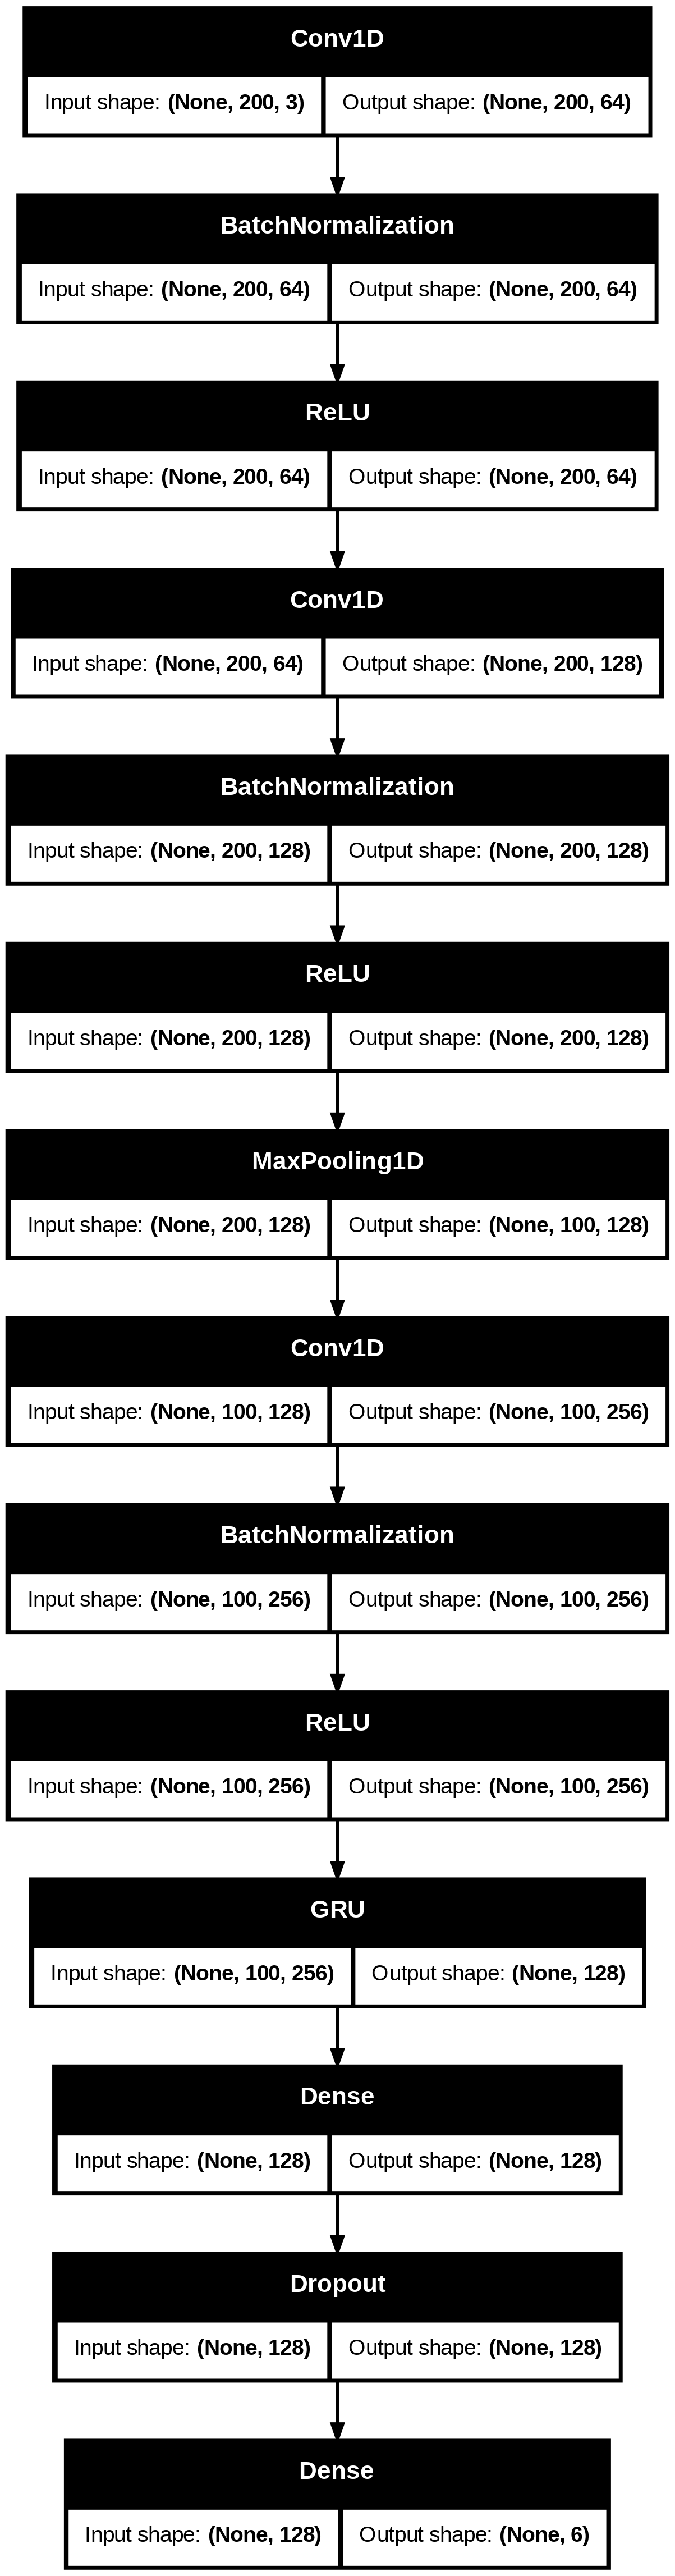

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_GRU_best.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5936 - sparse_categorical_accuracy: 0.7859
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.85268, saving model to WIDSM_HAR_CNN_GRU_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.5928 - sparse_categorical_accuracy: 0.7862 - val_loss: 0.5610 - val_sparse_categorical_accuracy: 0.8527
Epoch 2/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1088 - sparse_categorical_accuracy: 0.9616
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.85268
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1087 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.8991 - val_sparse_categorical_accuracy: 0.7880
Epoch 3/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.9662
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.85268
305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.1030 - sparse_categorical_accuracy: 0.9663 - val_loss: 1.1347 - val_sparse_categorical_accuracy: 0.7759
Epoch 4/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1412 - sparse_categorical_accuracy: 0.9539
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.85268


305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0335 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.5239 - val_sparse_categorical_accuracy: 0.8585
Epoch 6/100
302/305 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9867
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.85854
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0363 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.7483 - val_sparse_categorical_accuracy: 0.8237
Epoch 7/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9743
Epoch 7: val_sparse_categorical_accuracy improved from 0.85854 to 0.87854, saving model to WIDSM_HAR_CNN_GRU_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.5357 - val_sparse_categorical_accuracy: 0.8785
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0690 - sparse_categorical_accuracy: 0.9750
Epoch 8: val_sparse_categorical_accuracy improved from 0.87854 to 0.89000, saving model to WIDSM_HAR_CNN_GRU_best.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.5223 - val_sparse_categorical_accuracy: 0.8900
Epoch 9/100
302/305 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0850 - sparse_categorical_accuracy: 0.9744
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.89000
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0846 - sparse_categorical_accuracy: 0.9745 - val_loss: 1.4063 - val_sparse_categorical_accuracy: 0.7734
Epoch 10/100
302/305 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2239 - sparse_categorical_accuracy: 0.9345
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.89000
305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2221 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.8125 - val_sparse_categorical_accuracy: 0.8051
Epoch 11/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9694
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.890

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_GRU_best.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.29%
Training loss: 0.0199
Test accuracy: 95.37%
Test loss: 0.1926


In [ ]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8307    0.9075    0.8674       346
           1     0.9899    0.9673    0.9785      1316
           2     0.9933    0.9833    0.9883       300
           3     0.9688    0.9841    0.9764       189
           4     0.9033    0.7786    0.8364       384
           5     0.9550    0.9911    0.9727      1350

    accuracy                         0.9537      3885
   macro avg     0.9402    0.9353    0.9366      3885
weighted avg     0.9543    0.9537    0.9532      3885



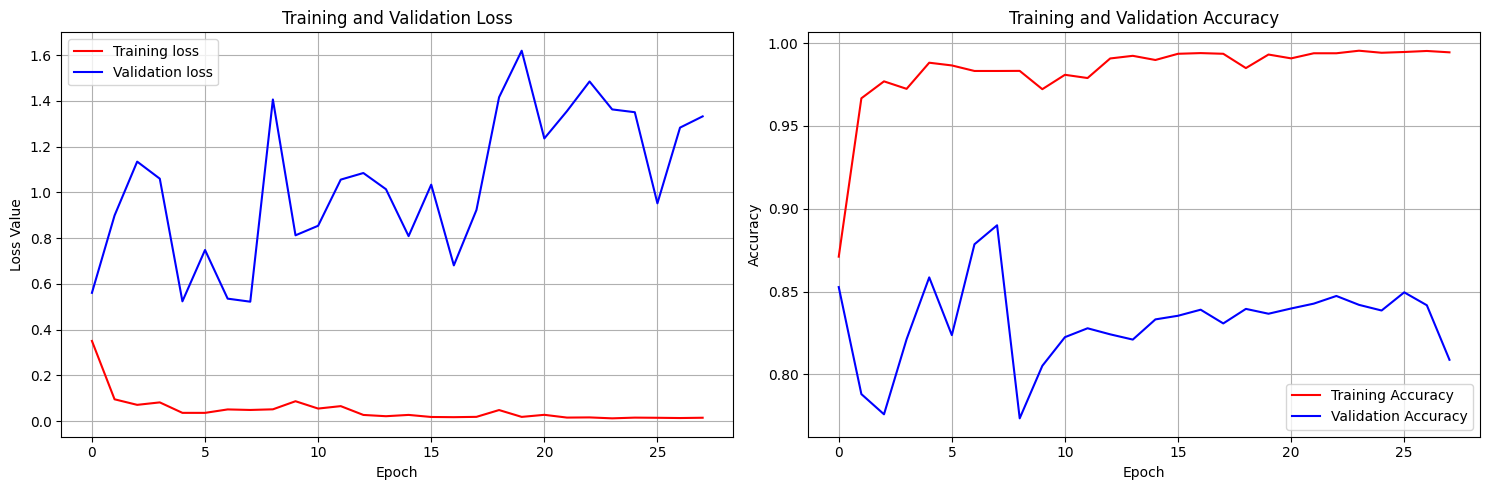

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

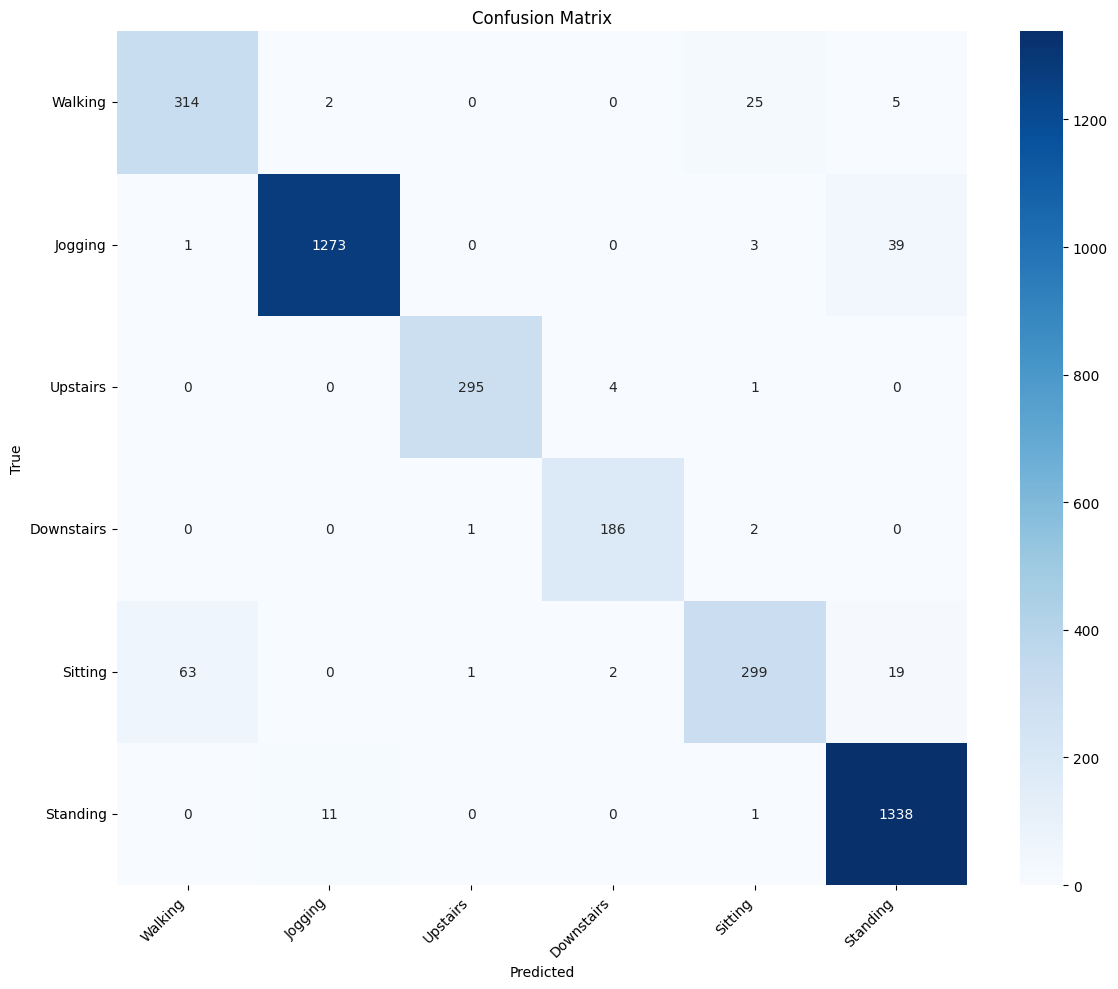

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 3, GRU 2

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(256, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GRU(128, return_sequences=True, dropout=0.2),
    GRU(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 200, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 128)       │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,662 (1.49 MB)

 Trainable params: 389,766 (1.49 MB)

 Non-trainable params: 896 (3.50 KB)

None


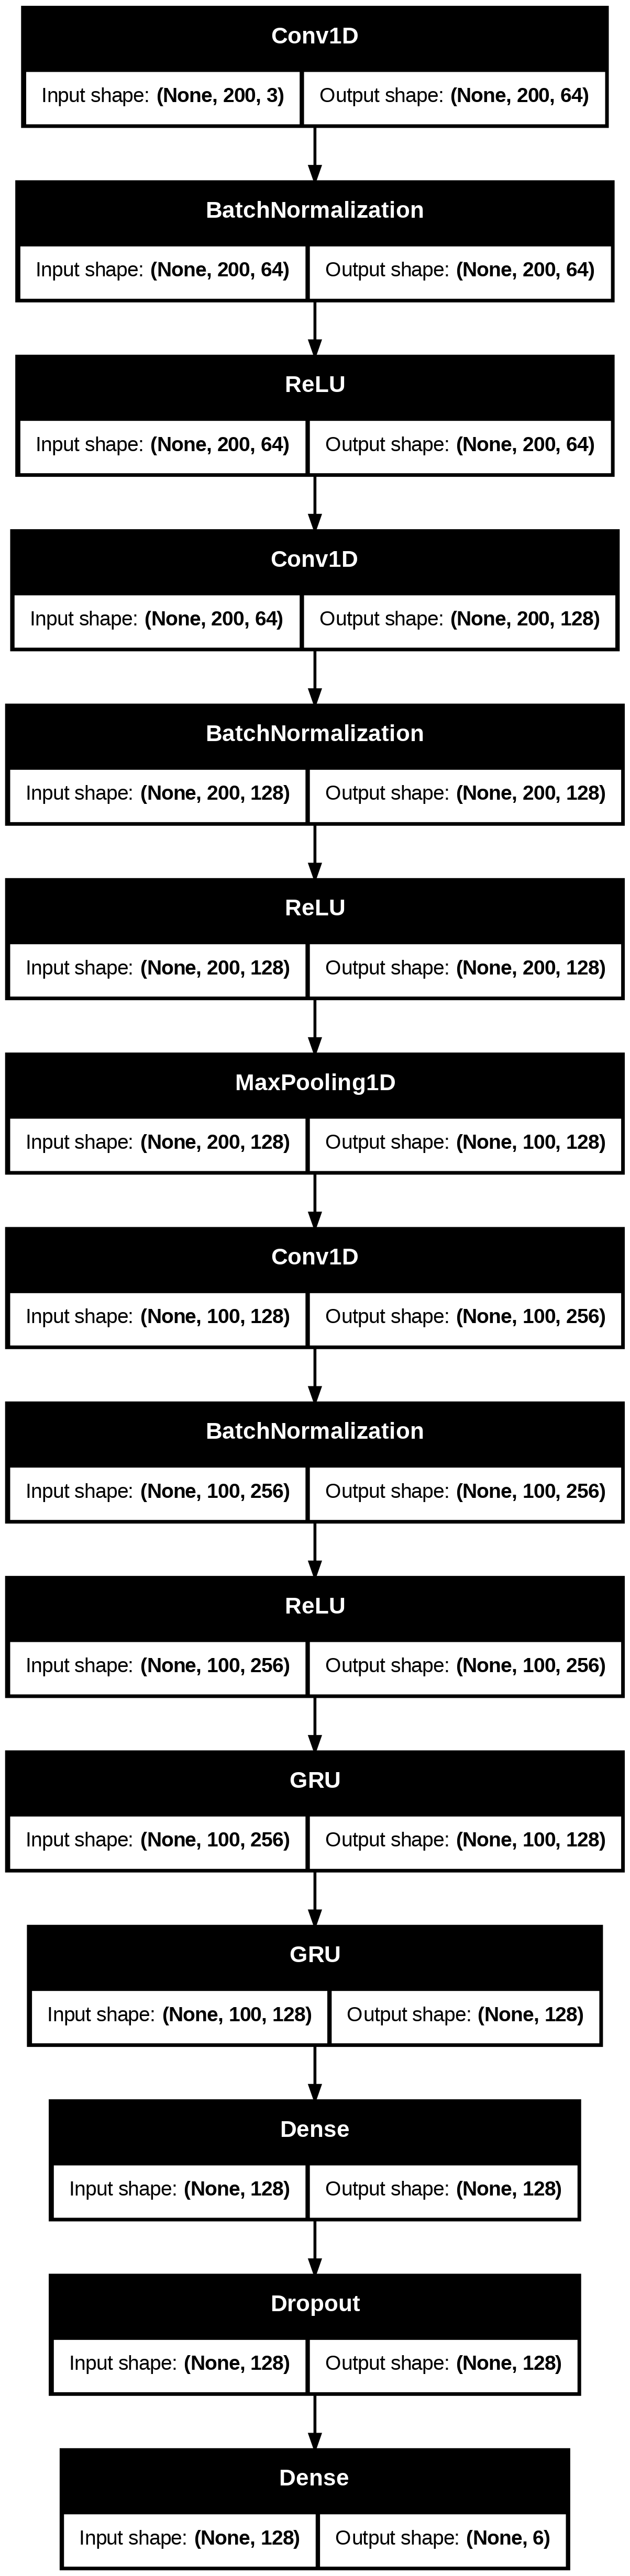

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_GRU_best2.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5949 - sparse_categorical_accuracy: 0.7892
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.68707, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.5941 - sparse_categorical_accuracy: 0.7895 - val_loss: 0.9723 - val_sparse_categorical_accuracy: 0.6871
Epoch 2/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.9475
Epoch 2: val_sparse_categorical_accuracy improved from 0.68707 to 0.77976, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1497 - sparse_categorical_accuracy: 0.9476 - val_loss: 1.2707 - val_sparse_categorical_accuracy: 0.7798
Epoch 3/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0741 - sparse_categorical_accuracy: 0.9746
Epoch 3: val_sparse_categorical_accuracy improved from 0.77976 to 0.79171, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0740 - sparse_categorical_accuracy: 0.9746 - val_loss: 1.2626 - val_sparse_categorical_accuracy: 0.7917
Epoch 4/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.9429
Epoch 4: val_sparse_categorical_accuracy improved from 0.79171 to 0.82146, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.1746 - sparse_categorical_accuracy: 0.9430 - val_loss: 1.0804 - val_sparse_categorical_accuracy: 0.8215
Epoch 5/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2154 - sparse_categorical_accuracy: 0.9381
Epoch 5: val_sparse_categorical_accuracy improved from 0.82146 to 0.82756, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.2144 - sparse_categorical_accuracy: 0.9384 - val_loss: 1.0184 - val_sparse_categorical_accuracy: 0.8276
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9844
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.82756
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9844 - val_loss: 1.4513 - val_sparse_categorical_accuracy: 0.8188
Epoch 7/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9819
Epoch 7: val_sparse_categorical_accuracy improved from 0.82756 to 0.82976, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9819 - val_loss: 1.2080 - val_sparse_categorical_accuracy: 0.8298
Epoch 8/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9877
Epoch 8: val_sparse_categorical_accuracy improved from 0.82976 to 0.83073, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9877 - val_loss: 1.4359 - val_sparse_categorical_accuracy: 0.8307
Epoch 9/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9912
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.83073
305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9912 - val_loss: 1.8507 - val_sparse_categorical_accuracy: 0.8022
Epoch 10/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9896
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.83073
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9896 - val_loss: 1.4852 - val_sparse_categorical_accuracy: 0.8305
Epoch 11/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0260 - sparse_categorical_accuracy: 0.9906
Epoch 11: val_sparse_categorical_accuracy improved from 0.83073 to

305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0261 - sparse_categorical_accuracy: 0.9906 - val_loss: 1.3163 - val_sparse_categorical_accuracy: 0.8315
Epoch 12/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.9930
Epoch 12: val_sparse_categorical_accuracy improved from 0.83146 to 0.83732, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.9930 - val_loss: 1.7202 - val_sparse_categorical_accuracy: 0.8373
Epoch 13/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0321 - sparse_categorical_accuracy: 0.9885
Epoch 13: val_sparse_categorical_accuracy improved from 0.83732 to 0.83854, saving model to WIDSM_HAR_CNN_GRU_best2.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0321 - sparse_categorical_accuracy: 0.9885 - val_loss: 1.4076 - val_sparse_categorical_accuracy: 0.8385
Epoch 14/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0237 - sparse_categorical_accuracy: 0.9906
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.83854
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9906 - val_loss: 1.5717 - val_sparse_categorical_accuracy: 0.8024
Epoch 15/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9378
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.83854
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.1967 - sparse_categorical_accuracy: 0.9381 - val_loss: 1.3131 - val_sparse_categorical_accuracy: 0.7551
Epoch 16/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9564
Epoch 16: val_sparse_categorical_accuracy did not improve from 

305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9751 - val_loss: 1.5311 - val_sparse_categorical_accuracy: 0.8441
Epoch 20/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9935
Epoch 20: val_sparse_categorical_accuracy did not improve from 0.84415
305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9935 - val_loss: 2.0027 - val_sparse_categorical_accuracy: 0.8227
Epoch 21/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1273 - sparse_categorical_accuracy: 0.9609
Epoch 21: val_sparse_categorical_accuracy did not improve from 0.84415
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1271 - sparse_categorical_accuracy: 0.9610 - val_loss: 1.8815 - val_sparse_categorical_accuracy: 0.8259
Epoch 22/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0564 - sparse_categorical_accuracy: 0.9841
Epoch 22: val_sparse_categorical_accuracy did not improve from 0

305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9938 - val_loss: 1.8601 - val_sparse_categorical_accuracy: 0.8466
Epoch 28/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9821
Epoch 28: val_sparse_categorical_accuracy did not improve from 0.84659
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9822 - val_loss: 1.9568 - val_sparse_categorical_accuracy: 0.8112
Epoch 29/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1212 - sparse_categorical_accuracy: 0.9674
Epoch 29: val_sparse_categorical_accuracy did not improve from 0.84659
305/305 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.1207 - sparse_categorical_accuracy: 0.9675 - val_loss: 1.8361 - val_sparse_categorical_accuracy: 0.8334
Epoch 30/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0250 - sparse_categorical_accuracy: 0.9913
Epoch 30: val_sparse_categorical_accuracy did not improve from 

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_GRU_best2.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.51%
Training loss: 0.0124
Test accuracy: 94.93%
Test loss: 0.3105


In [ ]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7621    0.9538    0.8472       346
           1     0.9891    0.9628    0.9757      1316
           2     0.9739    0.9933    0.9835       300
           3     0.9793    1.0000    0.9895       189
           4     0.9684    0.7188    0.8251       384
           5     0.9575    0.9837    0.9704      1350

    accuracy                         0.9493      3885
   macro avg     0.9384    0.9354    0.9319      3885
weighted avg     0.9542    0.9493    0.9488      3885



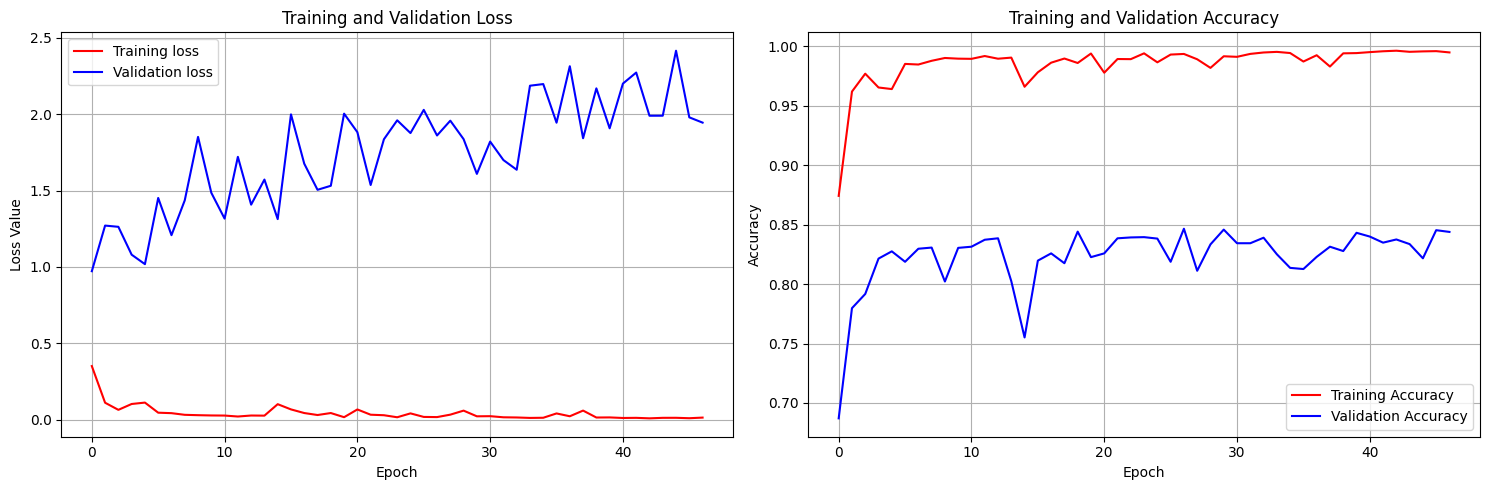

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

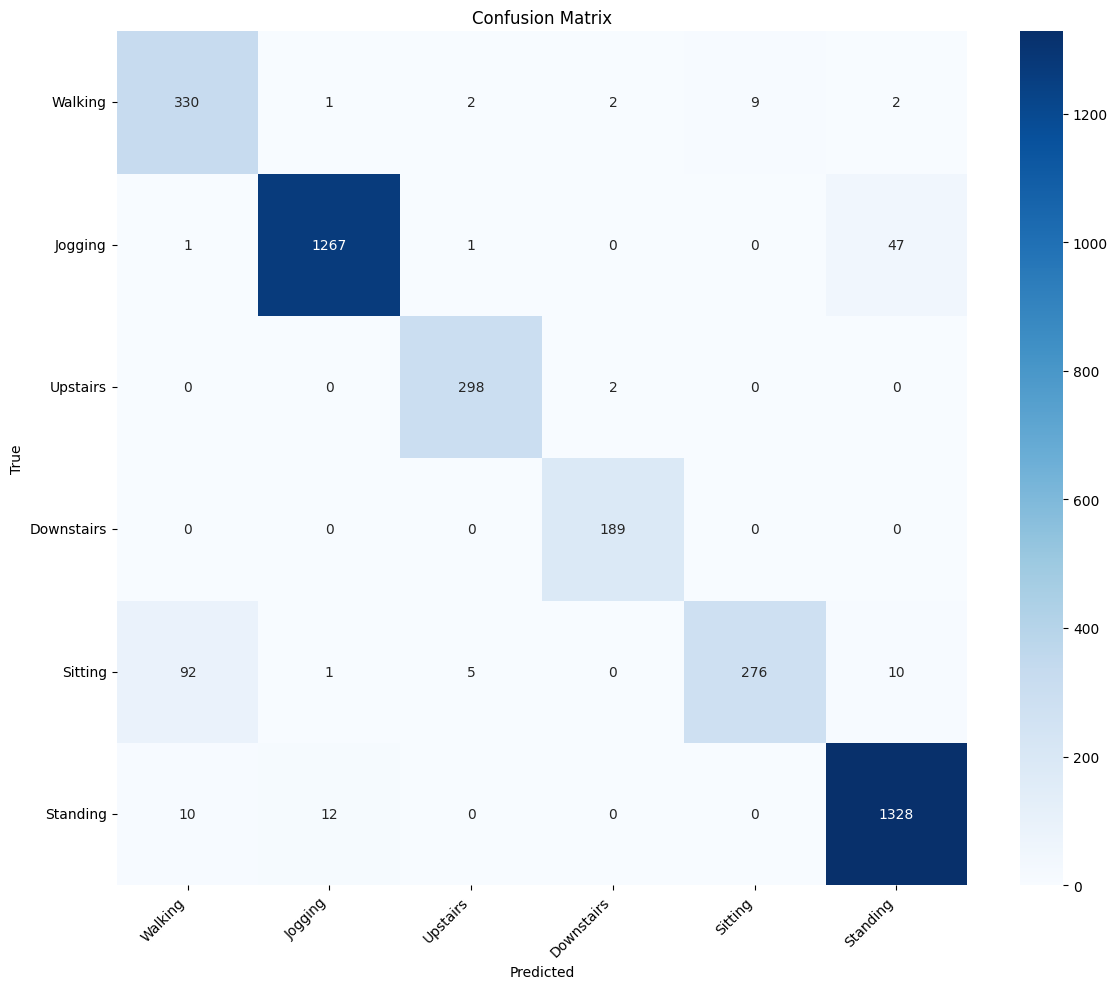

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()

## Model 3
- CNN 2, GRU 1

In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2])
num_classes = 6

model = Sequential([
    Input(shape=input_shape),

    Conv1D(64, 5, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPool1D(),

    Conv1D(128, 3, padding='same'),
    BatchNormalization(),
    ReLU(),

    GRU(128, return_sequences=False, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 100, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,854 (558.02 KB)

 Trainable params: 142,470 (556.52 KB)

 Non-trainable params: 384 (1.50 KB)

None


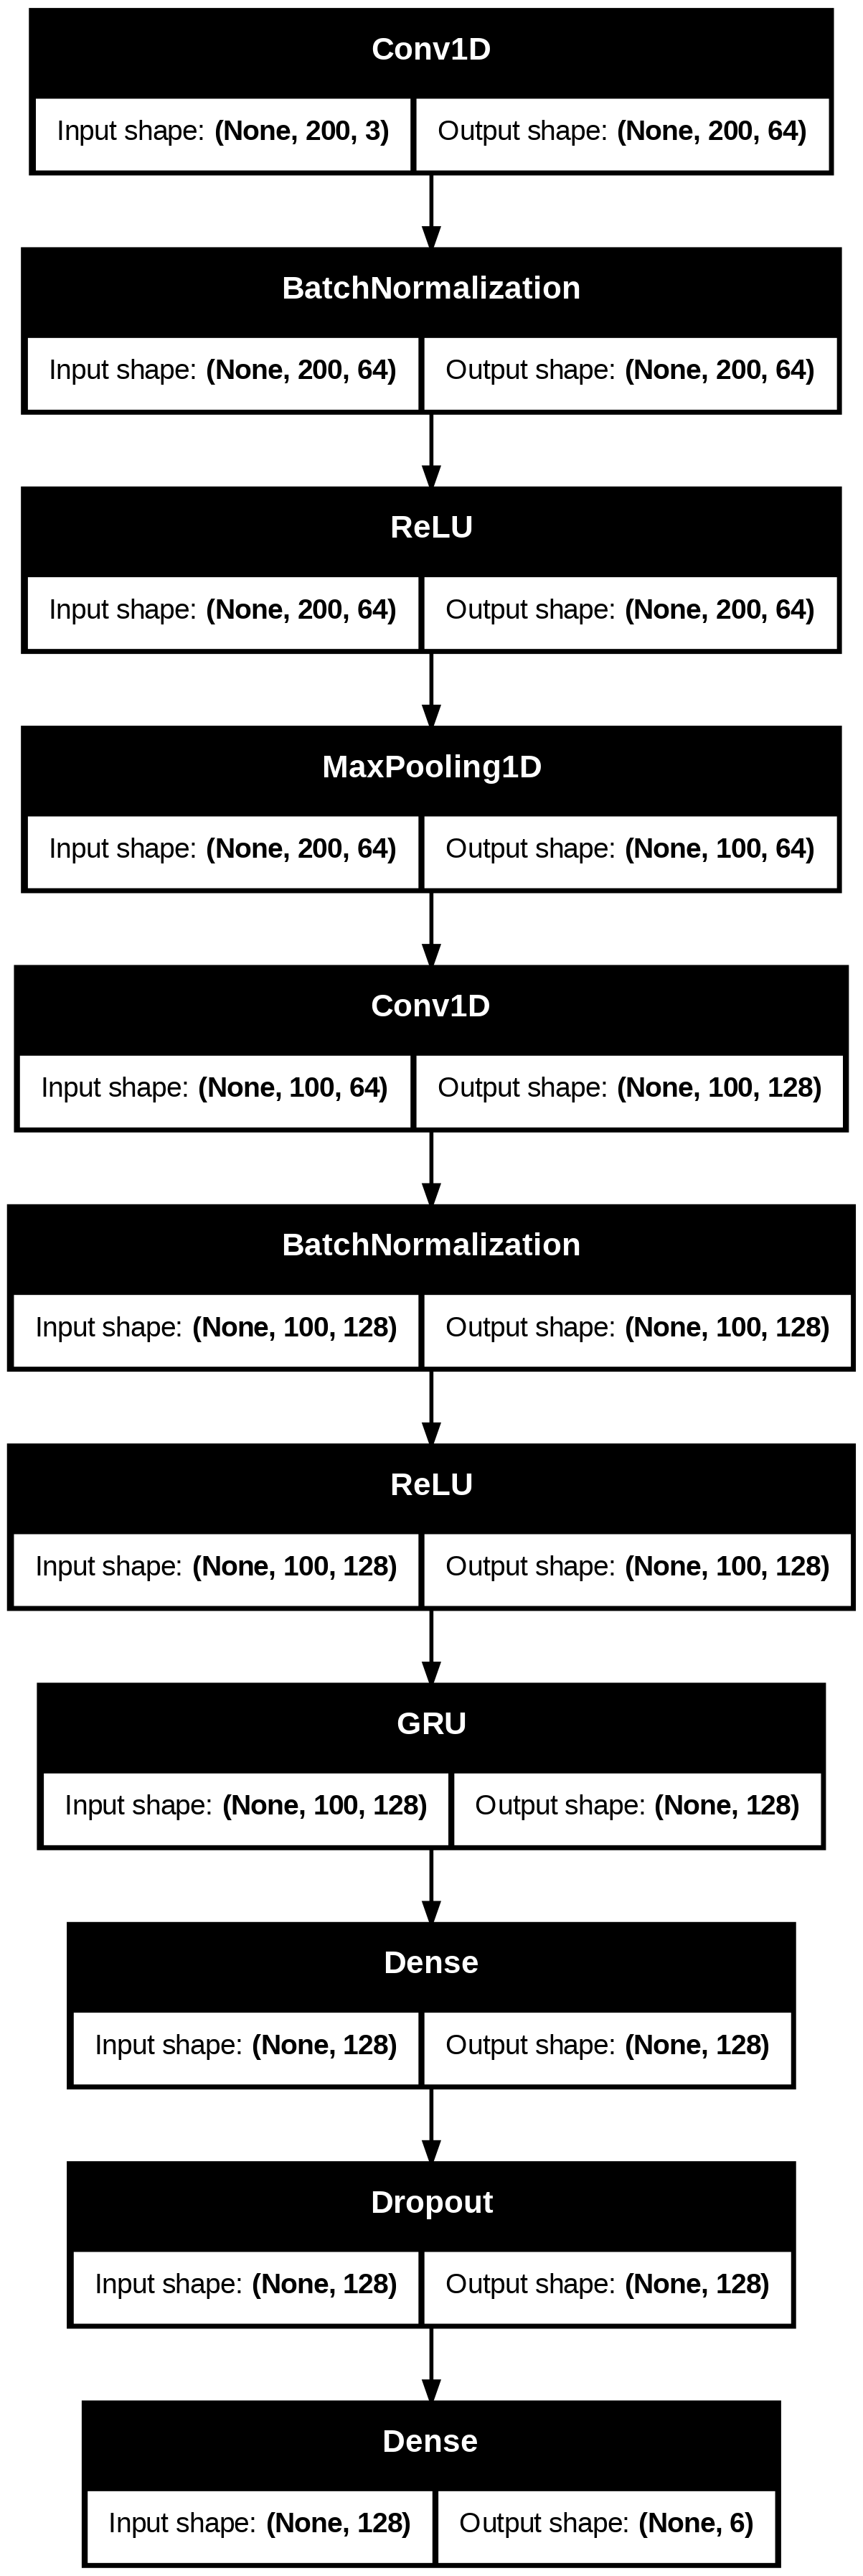

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "WIDSM_HAR_CNN_GRU_best3.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            x_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6984 - sparse_categorical_accuracy: 0.7555
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.70976, saving model to WIDSM_HAR_CNN_GRU_best3.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.6977 - sparse_categorical_accuracy: 0.7558 - val_loss: 1.2458 - val_sparse_categorical_accuracy: 0.7098
Epoch 2/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9349
Epoch 2: val_sparse_categorical_accuracy improved from 0.70976 to 0.78659, saving model to WIDSM_HAR_CNN_GRU_best3.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9350 - val_loss: 1.3288 - val_sparse_categorical_accuracy: 0.7866
Epoch 3/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.9427
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.78659
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9428 - val_loss: 1.1498 - val_sparse_categorical_accuracy: 0.7624
Epoch 4/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1491 - sparse_categorical_accuracy: 0.9509
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.78659
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9510 - val_loss: 1.4166 - val_sparse_categorical_accuracy: 0.7812
Epoch 5/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0547 - sparse_categorical_accuracy: 0.9807
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.78659
3

305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1434 - sparse_categorical_accuracy: 0.9523 - val_loss: 1.0441 - val_sparse_categorical_accuracy: 0.7873
Epoch 7/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0490 - sparse_categorical_accuracy: 0.9835
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.78732
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0490 - sparse_categorical_accuracy: 0.9835 - val_loss: 1.6609 - val_sparse_categorical_accuracy: 0.7795
Epoch 8/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9869
Epoch 8: val_sparse_categorical_accuracy improved from 0.78732 to 0.81122, saving model to WIDSM_HAR_CNN_GRU_best3.h5


305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9869 - val_loss: 1.2190 - val_sparse_categorical_accuracy: 0.8112
Epoch 9/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9857
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.81122
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0447 - sparse_categorical_accuracy: 0.9857 - val_loss: 1.4368 - val_sparse_categorical_accuracy: 0.7851
Epoch 10/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0787 - sparse_categorical_accuracy: 0.9787
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.81122
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9787 - val_loss: 1.2672 - val_sparse_categorical_accuracy: 0.7893
Epoch 11/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0362 - sparse_categorical_accuracy: 0.9874
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.811

305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0529 - sparse_categorical_accuracy: 0.9818 - val_loss: 1.5077 - val_sparse_categorical_accuracy: 0.8166
Epoch 15/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9934
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.81659
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9934 - val_loss: 1.7013 - val_sparse_categorical_accuracy: 0.8046
Epoch 16/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9771
Epoch 16: val_sparse_categorical_accuracy did not improve from 0.81659
305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0707 - sparse_categorical_accuracy: 0.9772 - val_loss: 1.6149 - val_sparse_categorical_accuracy: 0.7854
Epoch 17/100
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0233 - sparse_categorical_accuracy: 0.9920
Epoch 17: val_sparse_categorical_accuracy did not improve from 0.8

305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0145 - sparse_categorical_accuracy: 0.9951 - val_loss: 1.2033 - val_sparse_categorical_accuracy: 0.8315
Epoch 24/100
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9946
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.83146
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9946 - val_loss: 1.2664 - val_sparse_categorical_accuracy: 0.8134
Epoch 25/100
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0591 - sparse_categorical_accuracy: 0.9825
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.83146
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9825 - val_loss: 1.4879 - val_sparse_categorical_accuracy: 0.8217
Epoch 26/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9944
Epoch 26: val_sparse_categorical_accuracy did not improve from 0.8

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("WIDSM_HAR_CNN_GRU_best3.h5")

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 99.79%
Training loss: 0.0069
Test accuracy: 93.49%
Test loss: 0.3921


In [ ]:
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7917    0.9335    0.8568       346
           1     0.9968    0.9552    0.9756      1316
           2     0.9933    0.9933    0.9933       300
           3     0.9946    0.9735    0.9840       189
           4     0.8723    0.6406    0.7387       384
           5     0.9137    0.9807    0.9461      1350

    accuracy                         0.9349      3885
   macro avg     0.9271    0.9128    0.9157      3885
weighted avg     0.9370    0.9349    0.9331      3885



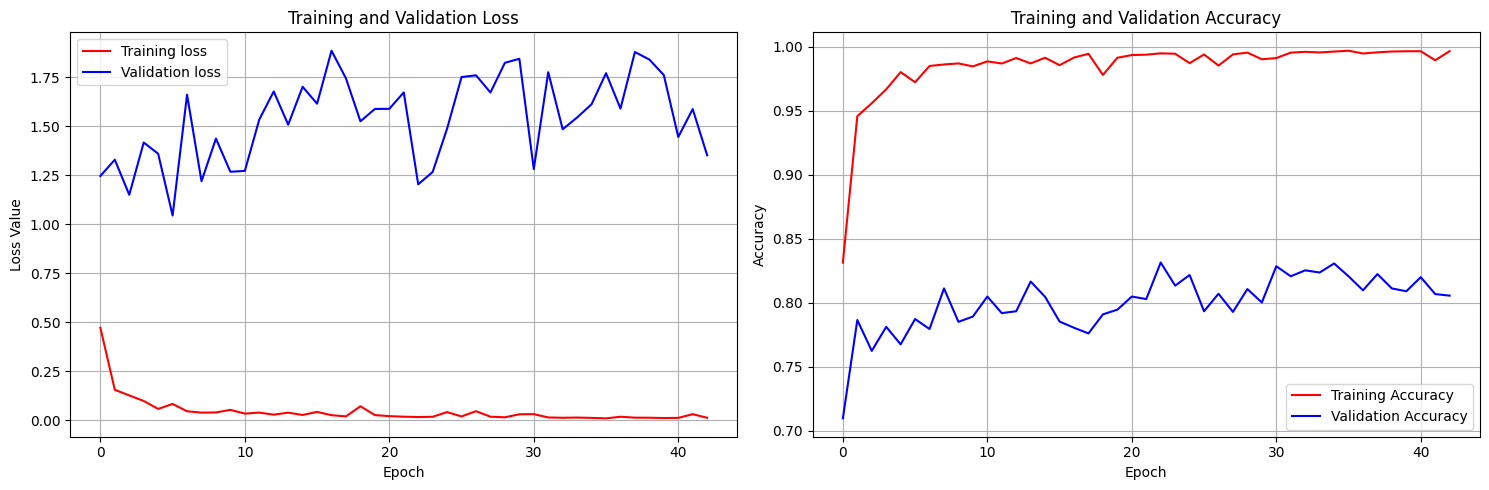

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

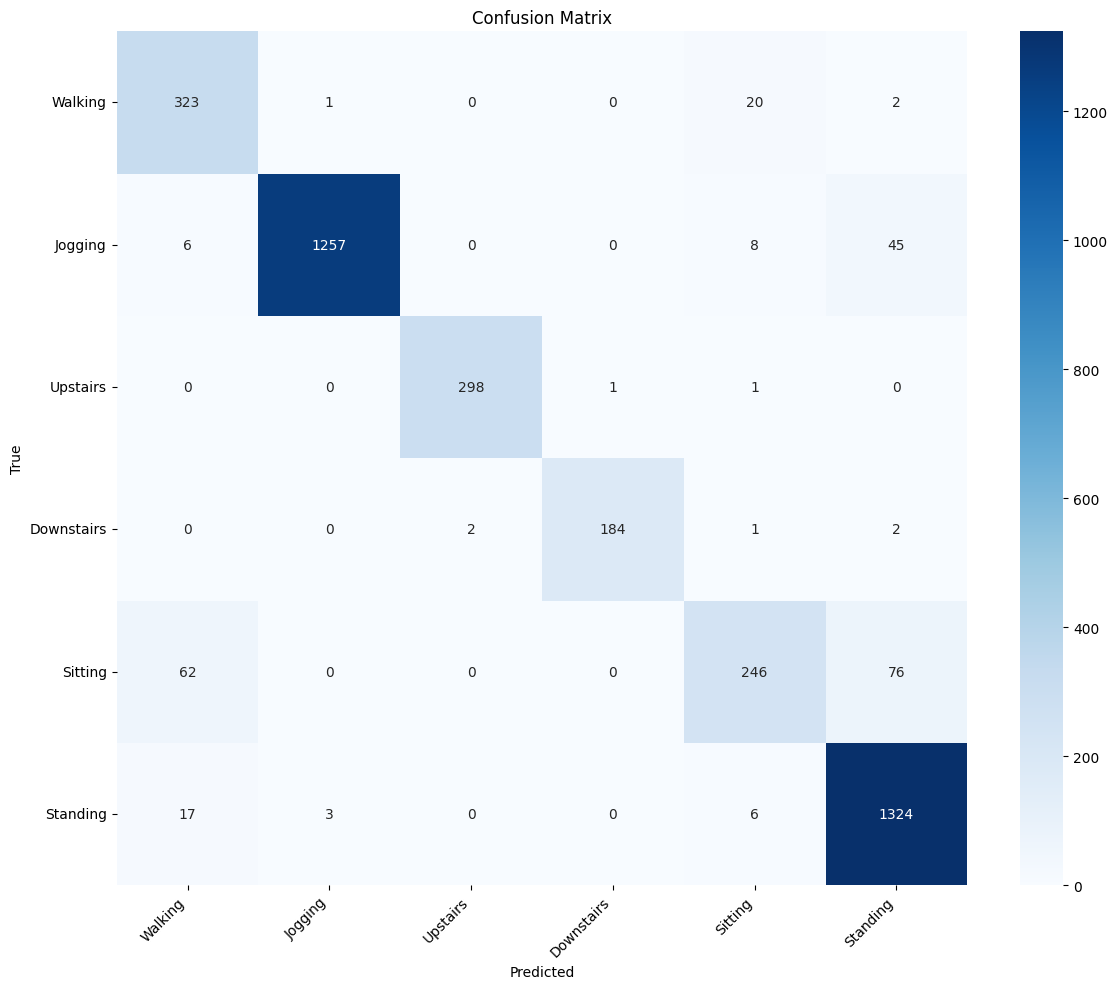

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

classes = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
plt.gca().set_xticklabels(classes, rotation=45, ha='right')
plt.gca().set_yticklabels(classes, rotation=0)

plt.tight_layout()
plt.show()